### Deep Learning in practice

#### In this activity I will build a simple cat neural network classifier with TensorFlow 2.0

* Build a neural network that classifies cat images
* Train the neural network
* and finally, evaluate the accuracy of the model

* **PIL** (Python Imaging Library) is the python Imaging library that adds support for opening, manipulating, and saving many different image file formats.
* **random** implements pseudo random number generators for various distributions
* **numpy**  for numpy array manipulation - every image must be embedded into a numpy before it can be used as input for a neural network
* **os** operating system module and allows access to folders and files stored in the hard drive - useful for navigating the file system
* **tensorflow.keras** tensorflow module that will be used to build our neural network model

In [1]:
#importing the required libraries
import tensorflow  as tf 
print(tf.__version__)

#import pillow
from PIL import Image
from random import shuffle, choice

#import numpy arrays library
import numpy as np

#import os module
import os
#import keras and its libs
from tensorflow.keras import datasets, layers, models, regularizers

#stop the execution from hanging, add this line to run training without interruption
os.environ ['KMP_DUPLICATE_LIB_OK'] = 'True'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime

2.16.1


### One-Hot Encoding

One-hot encoding takes a string as a parameter, and creates a label to the image.  Note that the label for a cat is  the numpy array [1,0] and the label for no cat is [0,1].  This technique is very common in machine learning.  **One-hot encoding** is a process by which categorical variables from string format to numerical format i.e. are converted into a format that could be provided to an ML algorithm to do a better prediction job.

*In one-hot encoding you create a vector containing all zeros except in one location*

The labels in the training data need to be one-hot encoded!

Think of a one-hot coded array [1,0] being the probability in this example of being or not being a cat

In [2]:
IMAGE_SIZE = 256 # we will be resizing the images to 256x256 pixels, this is a changeable hyperparameter
#increasing image size = longer training time but better accuracy
def one_hot_encode(className):
  '''One-hot encodes a given class'''
  if className == 'cats':return np.array([1,0])
  elif className =='nocats': return np.array([0,1])
  else: raise ValueError(f'Unknown class name: {className}')

In [3]:
print(f'cats: {one_hot_encode('cats')}')
print(f'cats: {one_hot_encode('nocats')}')

cats: [1 0]
cats: [0 1]


#### Loading the training data
The function **load_data** is responsible for loading the dataset.  First we set the IMAGE_DIRECTORY variable to point at the training dataset 'datasets/training_set'

The training data will be loaded into the list **train_data**.  Initially the list is empty.  Then the variable directories will get the tree structure of all directories in the specified path.

**os.walk()** generates the filenames in the directory tree by walking the tree either top-down or bottom-up.  For each directory in the tree rooted at directory top (including itself), it yields a 3-tuple (dirpath, dirnames, filenames)
* root: Prints out directories only from what we have specified
* dirs: Prints out sub-directories from the root
* files: Prints out all files from root and directories.

**os.path.join()** this python method joins one or more components intelligently.  This method concatenates various path components with exactly  one directory separator ('/') following each non-empty part except  the last path component.  If the last path component to be joined is empty then a directory separator('/' is put at the end.  If a path component represents an  absolute path, then all previous components joined are discarded and joining continues from the absolute path component)

In [4]:
# demo for generation of the os.walk(IMAGE_DIRECTORY) generator object and iteration on it
IMAGE_DIRECTORY = 'datasets/training_set'
print(f"os.walk(IMAGE_DIRECTORY: {os.walk(IMAGE_DIRECTORY)}")

#iterate over the generator object
i=0
for root, sub_directories, files in (os.walk(IMAGE_DIRECTORY)):
  print(f'Level {i}')
  print(f'root folder: {root}')
  print(f'sub folders: {sub_directories}')
  print(f'number of files in the root folder: {len(files)}')
  i +=1
  print("-"*35)
  
#returning folders we use the next method
folders = next(os.walk(IMAGE_DIRECTORY))
print(f'paths_tuple in the current directory: \n{folders}')
#returning the root folder
print(f'ROOT FOLDER:{folders[0]}')
#Sub directories in root
print(f'Subdirectories from the root: {folders[1]}')

#access the files
#print(f'Files at the root directory: {folders[2]}')

#directories
training_data_directory = folders[1]
print(f'Training Data Directory: {training_data_directory}')
cats_directory = training_data_directory[0]
nocats_directory = training_data_directory[1]

#reading the images with os.path.join()
joint_path = os.path.join(IMAGE_DIRECTORY,cats_directory)
print(f'Joint Path: {joint_path}')
images_list = next(os.walk(joint_path))[2] # file names are at index 2
print(f'number of images: {len(images_list)}') #prints images
#print(f'Image List: {images_list}')

os.walk(IMAGE_DIRECTORY: <generator object walk at 0x0000013686A7B290>
Level 0
root folder: datasets/training_set
sub folders: ['cats', 'nocats']
number of files in the root folder: 0
-----------------------------------
Level 1
root folder: datasets/training_set\cats
sub folders: []
number of files in the root folder: 4001
-----------------------------------
Level 2
root folder: datasets/training_set\nocats
sub folders: []
number of files in the root folder: 1669
-----------------------------------
paths_tuple in the current directory: 
('datasets/training_set', ['cats', 'nocats'], [])
ROOT FOLDER:datasets/training_set
Subdirectories from the root: ['cats', 'nocats']
Training Data Directory: ['cats', 'nocats']
Joint Path: datasets/training_set\cats
number of images: 4001


In [5]:
# Remodel the load method to use overloading / Parametric polymorphism so that the same method
# is used to laod both training and test data

""" def load_data (IMAGE_DIRECTORY, number_of_images = 100, shuffle_data = True):
  '''Loads the required image data'''
  print('loading images...')
  train_data =[]
  folders = next(os.walk(IMAGE_DIRECTORY))[1] # getting the sub directories
  
  for folder_name in folders:
    if folder_name: # ensure folder_name is not empty
      print(f'loading {folder_name}')
      file_names = next(os.walk(os.path.join(IMAGE_DIRECTORY, folder_name)))[2]
      for i in range(min(number_of_images, len(file_names))):
        image_name = choice(file_names)
        image_path=os.path.join(IMAGE_DIRECTORY, folder_name, image_name)

        if "DS_Store" not in  image_path:
          try:
              label = one_hot_encode(folder_name)
              class_name = folder_name
              img = Image.open(image_path) #Image.open() is part of the PILLOW library
              img = img.convert('L') #converts the image to grayscale
              img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.LANCZOS) # resize and improve quality
              train_data.append([np.array(img), label, class_name]) # class name is only needed for visualisation 
          except ValueError as e:
            print(e)
          except Exception as e:
            print(f'Error loading image {image_path}: {e}')    
  if(shuffle_data == True):
    shuffle(train_data)
  print(f'we loaded, {len(train_data)}, images in the training dataset')
  return train_data """
  
  
def load_data (IMAGE_DIRECTORY, number_of_images = 100, shuffle_data = True,dataSetType=None, tType="training" ):
  '''Loads the required image data'''
  
  if dataSetType is None:
    dataSetType =[]
  
  print('loading images...')
  folders = next(os.walk(IMAGE_DIRECTORY))[1] # getting the sub directories
  
  for folder_name in folders:
    if folder_name: # ensure folder_name is not empty
      print(f'loading {folder_name}')
      file_names = next(os.walk(os.path.join(IMAGE_DIRECTORY, folder_name)))[2]
      for i in range(min(number_of_images, len(file_names))):
        image_name = choice(file_names)
        image_path=os.path.join(IMAGE_DIRECTORY, folder_name, image_name)

        if "DS_Store" not in  image_path:
          try:
              label = one_hot_encode(folder_name)
              class_name = folder_name
              img = Image.open(image_path) #Image.open() is part of the PILLOW library
              img = img.convert('L') #converts the image to grayscale
              img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.LANCZOS) # resize and improve quality
              dataSetType.append([np.array(img), label, class_name]) # class name is only needed for visualisation 
          except ValueError as e:
            print(e)
          except Exception as e:
            print(f'Error loading image {image_path}: {e}')    
  if(shuffle_data == True):
    shuffle(dataSetType)
  print(f'we loaded, {len(dataSetType)}, images in the {tType} dataset')
  return dataSetType

#### Using the PILOW library to read image data from the file names

for i in range(number of images):
  image_path = choice(file_names)
  image_path = os.path.join(IMAGE_DIRECTORY, folder_name, image_name)
  label = one_hot_encode(folder_name)
  if "DS_Store" not in image_path:
    img = Image.open(image_path)
    img = img.convert('L')
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)
    train_data.append([np.array(img), label])

* **choice(file_names):** returns a random item from a list, tuple, or string - file_names is the image list in this case
* **Image.open(image_path):** open an image fro the path specified
* **img.resize:** resizes the image to the specified size
* **ANTIALIAS:** It is a filter that ensures the best quality
* **train_data.append([np.array(img), label]):** add the training images and their labels into the list
* **np.array(img):** cast the image into a numpy array

#### LOAD and VISUALISE Some Images

In [6]:
#check duration of loading the data
t0 = datetime.datetime.now()
IMAGE_DIRECTORY = 'datasets/training_set'
train_data = load_data(IMAGE_DIRECTORY, number_of_images=200, dataSetType=[], tType="training")
t1 = datetime.datetime.now()
print(f'time duration to load data: {t1-t0}')
#print(train_data)

loading images...
loading cats
loading nocats
we loaded, 399, images in the training dataset
time duration to load data: 0:00:01.753682


label [1 0]
class name: cats


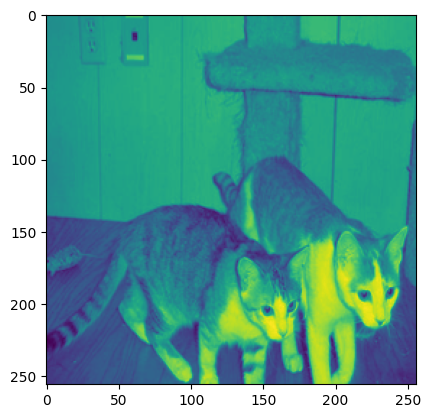

In [7]:
image_index =1
label = train_data[image_index][1]
class_name = train_data[image_index][2]
np_image =train_data[image_index][0]
print(f'label {label}')
print(f'class name: {class_name}')
image = plt.imshow(np_image) #display the image itself

label [0 1]
class name: nocats


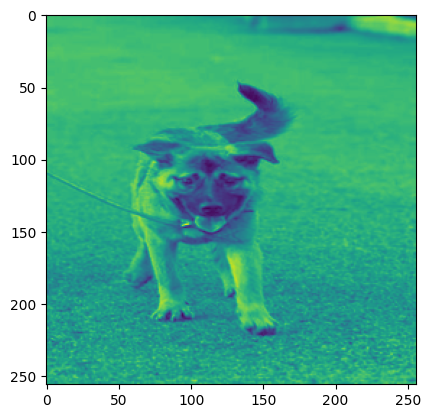

In [8]:
image_index =100
label = train_data[image_index][1]
class_name = train_data[image_index][2]
np_image =train_data[image_index][0]
print(f'label {label}')
print(f'class name: {class_name}')
image = plt.imshow(np_image) #display the image itself

#### Assignment
Perform the following steps both on your local machine and on Google Colab.

1. Create a simple dataset of images of cars and motorcycles.

2. Make sure to crop the images to only contain one object of interest

3. Organize your dataset into a training dataset and test dataset, in the same way of cats/not cats example.

4. The training dataset should contain around 100 images of each object (car, motorcycle)

5. The test dataset should contain 20 images of each object (car, motorcycle)

6. Reuse the load_data method to load the data that you collected.

7. Visualize a sample of your data to make sure that it is correctly inserted in the dataset.

8. Display the shape of your images (use numpy.shape function)



#### Reshape the np array

In [9]:
# Convert the first element of each item in train_data (which are the images) into a NumPy array,
# and reshape it to have the shape (-1, IMAGE_SIZE, IMAGE_SIZE, 1). The -1 means that the size
# of this dimension is inferred from the length of the array and the remaining dimensions.
# This reshaping step ensures that the images have the correct format expected by the model,
# with the last dimension being 1 to represent the grayscale channel.
trainX = np.array([i[0] for i in train_data]).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)

# Convert the second element of each item in train_data (which are the one-hot encoded labels)
# into a NumPy array. This will create an array where each element is a one-hot encoded vector
# representing the class label of the corresponding image.
trainY = np.array([i[1] for i in train_data])


print(trainX.shape)
print(trainY.shape)

(399, 256, 256, 1)
(399, 2)


#### Load test data and reshape the np array

In [10]:
#load test data
t0 - datetime.datetime.now()
IMAGE_DIRECTORY = 'datasets/test_set'
test_data = load_data(IMAGE_DIRECTORY, number_of_images=100, shuffle_data=True, dataSetType=[], tType="testing")
t1 = datetime.datetime.now()
print(f'Time taken to load data: {t1-t0}')

#reshape input arrays for the model
testX = np.array([i[0] for i in test_data]).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
testY = np.array([i[1] for i in test_data])
print(testX.shape)
print(testY.shape)

loading images...
loading cats
loading nocats
we loaded, 200, images in the testing dataset
Time taken to load data: 0:00:40.004507
(200, 256, 256, 1)
(200, 2)


#### Training a neural network

We will create two types of networks, One fully connected neural network and one convolutional neural network.

Create a convolutional neural network model

In [11]:
def create_cnn_model():
  '''Creates a CNN'''
  model = tf.keras.models.Sequential()
  #----------- start of feature extraction layers -----------------------------------
  
  model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu',
                          input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
  
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, kernel_size=(3,3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(256, kernel_size=(3,3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5)) # reduce overfitting recommended value is 0.5
  #Output from the convolutional layers is a summary of the most important features
  #------------------------------- end of feature extraction layers--------------------
  model.add(layers.Flatten()) # all features become one row i.e. flatten into 1D vector
  #-------------- Start of the classification layers  / head of the model--------------
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(2, activation ='softmax'))
  #softmax function returns a vector that contains two probabilities.  e.g. [0.7, 0.3]
  #----------------------- End of the classification layers -----------------------------
  return model

In [87]:
#improved model that uses regularizers
def create_cnn_model2():
    '''Creates a CNN'''
    model = tf.keras.models.Sequential()
    #----------- start of feature extraction layers -----------------------------------
    
    model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu',
                            input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
                            kernel_regularizer=regularizers.l2(0.00005)))
    
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu',
                            kernel_regularizer=regularizers.l2(0.00005)))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(128, kernel_size=(3,3), activation='relu',
                            kernel_regularizer=regularizers.l2(0.00005)))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(256, kernel_size=(3,3), activation='relu',
                            kernel_regularizer=regularizers.l2(0.00005)))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dropout(0.5)) # reduce overfitting recommended value is 0.5
    #Output from the convolutional layers is a summary of the most important features
    #------------------------------- end of feature extraction layers--------------------
    
    model.add(layers.Flatten()) # all features become one row i.e. flatten into 1D vector
    #-------------- Start of the classification layers  / head of the model--------------
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.000051)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.00005)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(2, activation ='softmax', kernel_regularizer=regularizers.l2(0.00005)))
    #softmax function returns a vector that contains two probabilities.  e.g. [0.7, 0.3]
    #----------------------- End of the classification layers -----------------------------
    return model

#### Compile the model

* **binary_crossentropy** Use Binary Cross Entropy when the output of the model is from a sigmoid function that returns a probability of being cat or no cat.  In our case we are dealing with two classes and two probabilities so it is better to use Categorical Cross Entropy Loss, although Binary loss could be used with two classes.

* *Sigmoid function* returns one value which is probability between 0 and 1
* *Stochaistic gradient descent (s)* is our optimiser but we can also use the **adam optimiser**, setting the optimiser as *sgd* will take the sgd default parameters. i.e. learning rate and momentum
* metric to monitor will be the accuracy

In [12]:
print('creating model')
model = create_cnn_model()
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
#

creating model


c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Final step is to train the model

* BATCH_SIZE - must be as high as possible but make sure it is not too high to exceed existing memory
* verbose will show the output
* validation_data is needed if you wat to monitor the validation loss and validation accuracy during the training.

In [13]:
print('Training model')
BATCH_SIZE = 64 
EPOCHS = 15
'''history = model.fit(trainX, trainY,
                    batch_size = BATCH_SIZE,
                    epochs=10,
                    verbose =1,
                    validation_data =(testX, testY))'''
                    
history = model.fit(trainX, trainY,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(testX, testY),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Training model
Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5975 - loss: 1.3608 - val_accuracy: 0.5000 - val_loss: 2.4370
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7588 - loss: 0.5573 - val_accuracy: 0.5000 - val_loss: 2.4869
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7875 - loss: 0.5076 - val_accuracy: 0.5100 - val_loss: 2.3257
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8273 - loss: 0.4052 - val_accuracy: 0.5100 - val_loss: 1.3836
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7767 - loss: 0.5041 - val_accuracy: 0.5150 - val_loss: 1.0597
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9289 - loss: 0.1839 - val_accuracy: 0.5100 - val_loss: 1.4512
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9475 - loss: 0.1409 - val_accuracy: 0.5400 - val_loss: 1.0741
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9619 - loss: 0.1356 - val_accuracy: 0.5750 - val_loss: 

* if the training accuracy is excellent e.g. 100% but the validation accuracy is low then we would say we have **overfitting** i.e. the model is doing too well on what it has seen but poor at at generalising on the unseen data.

* The gap between training and validation accuracy, coupled with the higher validation loss, suggests that the model might be overfitting. The model performs very well on the training data but not as well on the validation data.

![Overfitting](./overfitting.png)

**Possible Solution**
* Increase the size of the training dataset i.e. add more images in the dataset
* Introduce Data augmentation
* Reduce the size of the neural network model i.e. have less learnable parameters

**More Practical suggestions to counter overfitting**
* **L2 regularization** (Weight Decay): Add a penalty for large weight to the loss function, **Dropout**: Randomly drops a fraction of the neurons during training to prevent over-reliance on specific neurons
* **Data Augmentation**: Increase the size and variability of the training data by applying transformations such as rotations, flips and shifts
* **Early stopping**: Monitor the validation loss during training and stop the training when the validation loss stops improving
* **Simplify the model**: reduce the complexity of th model by decreasing the number of layers or neurons
* **Cross-validation**: use k-fold cross valudation to ensure the model generalises well on different subsets of the data

#### Check model summary for trainable parameters

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,820,804 (26.02 MB)

 Trainable params: 6,819,842 (26.02 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 2 (12.00 B)

#### Saving finished models

In [15]:
model.save('model_cnn1.h5')

In [75]:
#Plot the History
def plot_history(history):
  #summary history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  #summary history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
[0.5049999952316284, 0.5375000238418579, 0.5049999952316284, 0.4749999940395355, 0.5174999833106995, 0.6025000214576721, 0.6499999761581421, 0.6474999785423279, 0.625, 0.6625000238418579, 0.5975000262260437, 0.5625, 0.6575000286102295, 0.7599999904632568, 0.6775000095367432, 0.6825000047683716, 0.6474999785423279, 0.5224999785423279, 0.6349999904632568, 0.7099999785423279, 0.6875, 0.6150000095367432, 0.7925000190734863, 0.637499988079071, 0.5724999904632568]
[0.5, 0.6000000238418579, 0.5, 0.5074999928474426, 0.612500011920929, 0.5425000190734863, 0.6200000047683716, 0.5525000095367432, 0.6399999856948853, 0.637499988079071, 0.5400000214576721, 0.5649999976158142, 0.7250000238418579, 0.5824999809265137, 0.7799999713897705, 0.5799999833106995, 0.5024999976158142, 0.6675000190734863, 0.6575000286102295, 0.6424999833106995, 0.5525000095367432, 0.8149999976158142, 0.6700000166893005, 0.5, 0.5550000071525574]


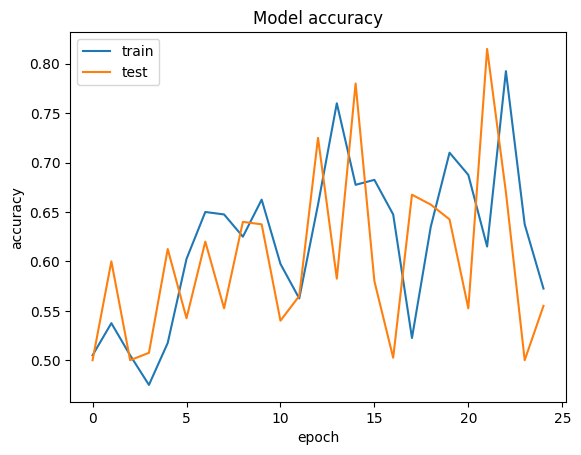

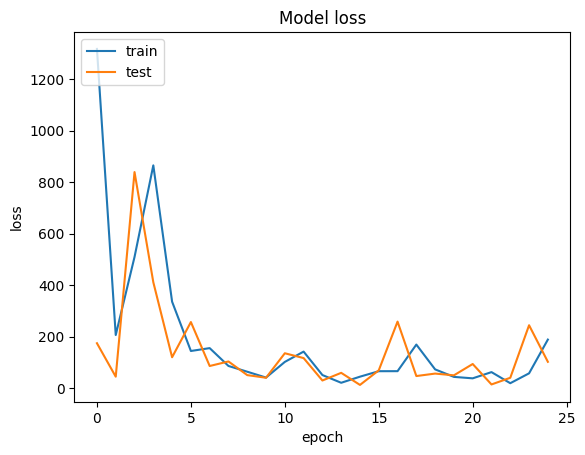

In [83]:
#cech for elements in the history object
print(history.history.keys())
print(history.history['accuracy'])
print(history.history['val_accuracy'])
plot_history(history)

#### Create a fully connected Neural Network

* Softmax and ReLU (Rectified Linear Unit) are both activation functions commonly used in neural networks but serve different purposes
* Sofmax is used in the output layer of a classification model to produce a probability distribution pver mutually exclusive classes
*  Softmax takes a vector K real numbers and transforms it into a vector K real-valued outputs in the range (0,1) that add up to 1

![Softmax](./softMax.png)

* ReLU - used in hidden layers of a neural network to introduce non-linearity, helping the model to learn complex patterns.  ReLU  outputs the input directly if it is positive  otherwise it outputs zero.

![ReLU](./reLU.png)

In [77]:
def fully_connected_model():
  '''Fully connected model with no covolutions'''
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape =(IMAGE_SIZE, IMAGE_SIZE, 1))) # flatten the input as it only takens one vector 
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(2, activation='softmax'))
  return model

In [80]:
#Training is similar except that we have chosen the adam optimiser

print('creating model')
model = fully_connected_model()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Training model')
BATCH_SIZE = 64 
EPOCHS = 100
'''history = model.fit(trainX, trainY,
                    batch_size = BATCH_SIZE,
                    epochs=10,
                    verbose =1,
                    validation_data =(testX, testY))'''
                    
history = model.fit(trainX, trainY,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(testX, testY),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

creating model
Training model
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.4857 - loss: 1136.9417 - val_accuracy: 0.5000 - val_loss: 174.7035
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5229 - loss: 228.9969 - val_accuracy: 0.6000 - val_loss: 44.8076
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5133 - loss: 353.7309 - val_accuracy: 0.5000 - val_loss: 839.5374
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4907 - loss: 896.7938 - val_accuracy: 0.5075 - val_loss: 411.6564
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5021 - loss: 363.1414 - val_accuracy: 0.6125 - val_loss: 120.2748
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6197 - loss: 137.4333 - val_accuracy: 0.5425 - val_loss: 256.9888
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6554 - loss: 160.1247 - val_accuracy: 0.6200 - val_loss: 86.2492
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy:

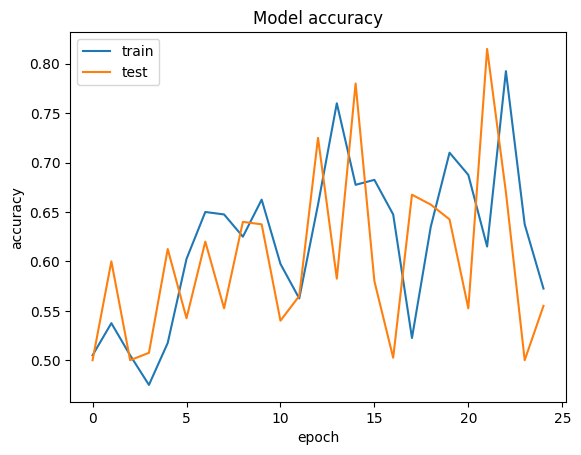

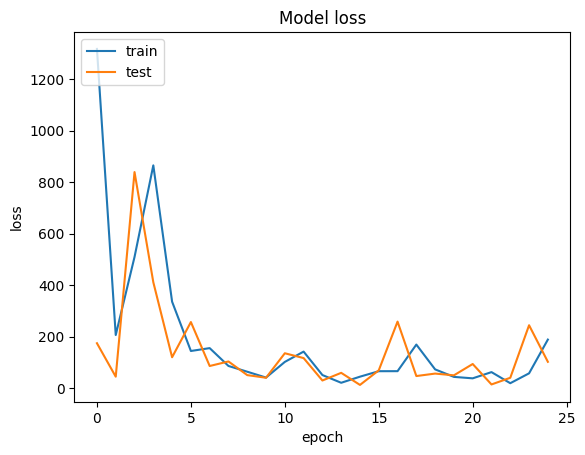

In [84]:
plot_history(history)